# **Visual Sound Detection Model**

This notebook builds a computer vision classifier that learns from images located in the `images` folder. Each image file name is interpreted as its label. The pipeline covers environment setup, data ingestion, preprocessing, model training, evaluation, and an optional realtime webcam inference demo.

> **Note:** Add your images to `images/` before running the training steps. The notebook assumes a standard RGB image format (e.g., `.jpg`, `.png`).


In [21]:
import os
import sys
import math
import json
from pathlib import Path
from typing import Callable, Dict, List, Tuple

import numpy as np
import pandas as pd
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Optional: used later for webcam capture
try:
    import cv2
except ImportError:
    cv2 = None
    print("OpenCV (cv2) not found. Webcam inference cell will guide you through installing it.")

# Configure paths
PROJECT_ROOT = Path("/Users/raoabdul/Documents/Development/NextGen-Innovators/ML Model")
IMAGE_DIR = PROJECT_ROOT / "images"
ARTIFACT_DIR = PROJECT_ROOT / "artifacts"
ARTIFACT_DIR.mkdir(parents=True, exist_ok=True)

# Basic reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print(f"TensorFlow version: {tf.__version__}")
print(f"Looking for images in: {IMAGE_DIR}")


TensorFlow version: 2.20.0
Looking for images in: /Users/raoabdul/Documents/Development/NextGen-Innovators/ML Model/images


## **1. Dataset Discovery & Label Parsing**

This section scans the `images` directory, extracts labels from file names, and builds a dataframe describing the dataset. Customize `extract_label_from_name` if you prefer a different naming convention.


In [22]:
def extract_label_from_name(filename: str) -> str:
    """Derive a label from the image filename (without the extension).

    Strategy:
      1. Remove the file extension.
      2. Split on underscores, dashes, or spaces.
      3. Use the first token as the class name.

    Adjust this heuristic to match your naming scheme.
    """
    stem = Path(filename).stem
    for delimiter in ("_", "-", " "):
        if delimiter in stem:
            return stem.split(delimiter)[0].lower()
    return stem.lower()


def discover_dataset(image_dir: Path) -> pd.DataFrame:
    """Return a dataframe with columns [path, label]."""
    image_paths = sorted(
        p for p in image_dir.glob("**/*") if p.is_file() and p.suffix.lower() in {".jpg", ".jpeg", ".png", ".bmp"}
    )
    if not image_paths:
        raise FileNotFoundError(
            f"No images found in {image_dir}. Add files before running training."
        )
    records = []
    for path in image_paths:
        label = extract_label_from_name(path.name)
        records.append({"path": path, "label": label})
    df = pd.DataFrame(records)
    return df


def summarize_dataset(df: pd.DataFrame) -> None:
    """Print summary statistics and plot label distribution."""
    print(f"Total images: {len(df)}")
    label_counts = df["label"] .value_counts().sort_values(ascending=False)
    print("Label distribution:")
    print(label_counts)

    plt.figure(figsize=(10, 4))
    sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")
    plt.xticks(rotation=45, ha="right")
    plt.xlabel("Label")
    plt.ylabel("Count")
    plt.title("Image count per label")
    plt.tight_layout()
    plt.show()


def train_val_test_split(
    df: pd.DataFrame,
    train_frac: float = 0.7,
    val_frac: float = 0.2,
    test_frac: float = 0.1,
    seed: int = 42,
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Split the dataframe into train/validation/test subsets stratified by label.
    For very small datasets (<20 images total), adjusts splits automatically.
    """
    if not math.isclose(train_frac + val_frac + test_frac, 1.0, rel_tol=1e-5):
        raise ValueError("train_frac + val_frac + test_frac must sum to 1.0")

    total_images = len(df)
    num_classes = len(df["label"] .unique())
    images_per_class = total_images // num_classes if num_classes > 0 else 0

    # Adjust splits for very small datasets
    if total_images < 20:
        # For very small datasets, use larger train split, skip test if too small
        train_frac = 0.80
        val_frac = 0.10
        test_frac = 0.10
        print(f"⚠️  Very small dataset detected ({total_images} images). Using adjusted splits: 85% train, 15% val, 0% test")

    df_shuffled = df.sample(frac=1.0, random_state=seed).reset_index(drop=True)
    splits: Dict[str, List[pd.Series]] = {"train": [], "val": [], "test": []}

    for label, group in df_shuffled.groupby("label"):
        n = len(group)
        n_train = max(1, int(n * train_frac))
        n_val = max(1, int(n * val_frac)) if n >= 3 and val_frac > 0 else 0
        n_test = n - n_train - n_val if test_frac > 0 else 0
        splits["train"] .append(group.iloc[:n_train])
        if n_val > 0:
            splits["val"] .append(group.iloc[n_train : n_train + n_val])
        if n_test > 0:
            splits["test"] .append(group.iloc[n_train + n_val :])

    train_df = pd.concat(splits["train"]).reset_index(drop=True)
    val_df = pd.concat(splits["val"]).reset_index(drop=True) if splits["val"] else pd.DataFrame()
    test_df = pd.concat(splits["test"]).reset_index(drop=True) if splits["test"] else pd.DataFrame()

    print(
        f"Split counts -> train: {len(train_df)}, val: {len(val_df)}, test: {len(test_df)}"
    )
    return train_df, val_df, test_df


,path,label
0,/Users/raoabdul/Documents/Development/NextGen-...,gspotted
1,/Users/raoabdul/Documents/Development/NextGen-...,gspotted
2,/Users/raoabdul/Documents/Development/NextGen-...,gspotted
3,/Users/raoabdul/Documents/Development/NextGen-...,gspotted
4,/Users/raoabdul/Documents/Development/NextGen-...,gspotted


Total images: 20
Label distribution:
label
gspotted    10
greater     10
Name: count, dtype: int64


/var/folders/lf/wzrn2w4j7mq_hf01km30xn0c0000gn/T/ipykernel_15874/2039753807.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")


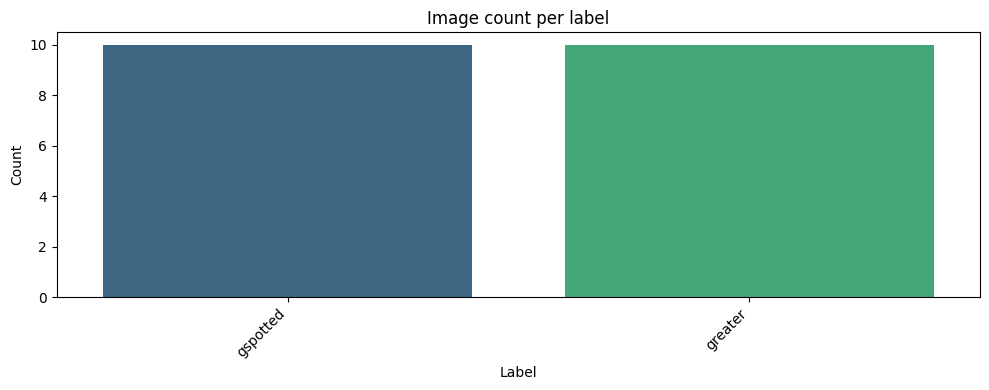

In [23]:
try:
    dataset_df = discover_dataset(IMAGE_DIR)
    display(dataset_df.head())
    summarize_dataset(dataset_df)
except FileNotFoundError as e:
    dataset_df = None
    print(e)
    print("Populate the images directory and rerun this cell when ready.")


## **2. Preprocessing Pipeline**

This section builds TensorFlow `tf.data.Dataset` pipelines with on-the-fly preprocessing and optional augmentation. Adjust the image size or augmentations to suit your dataset.


In [24]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
AUTOTUNE = tf.data.AUTOTUNE


def load_image(path: tf.Tensor) -> tf.Tensor:
    """Load an image from disk and resize it."""
    image = tf.io.read_file(path)
    image = tf.io.decode_image(image, channels=3, expand_animations=False)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, IMG_SIZE)
    return image


def build_dataset(
    df: pd.DataFrame,
    class_to_index: Dict[str, int],
    augment: bool = False,
    aggressive_augment: bool = False,
    very_small_dataset: bool = False,
) -> tf.data.Dataset:
    paths = df["path"] .astype(str).values
    labels = df["label"] .map(class_to_index).values

    ds = tf.data.Dataset.from_tensor_slices((paths, labels))

    def _load_and_preprocess(path, label):
        image = load_image(path)
        if augment:
            image = augment_image(image, aggressive=aggressive_augment, very_small_dataset=very_small_dataset)
        return image, tf.one_hot(label, depth=len(class_to_index))

    ds = ds.shuffle(len(df), seed=SEED)
    ds = ds.map(_load_and_preprocess, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds


def augment_image(image: tf.Tensor, aggressive: bool = True, very_small_dataset: bool = False) -> tf.Tensor:
    """
    Apply data augmentation. 
    - aggressive=True: Standard aggressive augmentation
    - very_small_dataset=True: Maximum augmentation for datasets <15 images per class
    """
    # Random flips (always applied)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    if very_small_dataset:
        # MAXIMUM augmentation for very small datasets (11 images per class)
        # Color augmentations
        image = tf.image.random_brightness(image, max_delta=0.4)
        image = tf.image.random_contrast(image, 0.6, 1.4)
        image = tf.image.random_saturation(image, 0.5, 1.5)
        image = tf.image.random_hue(image, max_delta=0.15)
        
        # Geometric augmentations
        # Random rotation (90 degree increments)
        image = tf.image.rot90(image, k=tf.random.uniform([], 0, 4, dtype=tf.int32))
        
        # Random zoom via crop and resize
        crop_size = int(IMG_SIZE[0] * tf.random.uniform([], 0.7, 0.95))
        if crop_size > 0:
            image = tf.image.random_crop(image, size=[crop_size, crop_size, 3])
            image = tf.image.resize(image, IMG_SIZE)
        
        # Random translation (shift)
        image = tf.image.random_crop(image, size=[int(IMG_SIZE[0]*0.9), int(IMG_SIZE[1]*0.9), 3])
        image = tf.image.resize(image, IMG_SIZE)
        
    elif aggressive:
        # Standard aggressive augmentation
        image = tf.image.random_brightness(image, max_delta=0.3)
        image = tf.image.random_contrast(image, 0.7, 1.3)
        image = tf.image.random_saturation(image, 0.6, 1.4)
        image = tf.image.random_hue(image, max_delta=0.1)
        # Random rotation (90 degree increments)
        image = tf.image.rot90(image, k=tf.random.uniform([], 0, 4, dtype=tf.int32))
        # Random zoom via crop and resize
        crop_size = int(IMG_SIZE[0] * 0.8)
        if crop_size > 0:
            image = tf.image.random_crop(image, size=[crop_size, crop_size, 3])
            image = tf.image.resize(image, IMG_SIZE)
    else:
        # Mild augmentation
        image = tf.image.random_brightness(image, max_delta=0.1)
        image = tf.image.random_contrast(image, 0.9, 1.1)
    
    # Ensure values stay in [0, 1]
    image = tf.clip_by_value(image, 0.0, 1.0)
    return image


def prepare_datasets(df: pd.DataFrame):
    labels = sorted(df["label"] .unique())
    class_to_index = {label: idx for idx, label in enumerate(labels)}
    index_to_class = {idx: label for label, idx in class_to_index.items()}

    # Detect dataset size and choose augmentation strategy
    total_images = len(df)
    num_classes = len(labels)
    images_per_class = total_images // num_classes if num_classes > 0 else 0
    
    # Determine augmentation level
    use_very_small_aug = images_per_class < 15  # Maximum augmentation for very small datasets
    use_aggressive_aug = images_per_class < 50 and not use_very_small_aug  # Standard aggressive for small datasets

    train_df, val_df, test_df = train_val_test_split(df)

    train_ds = build_dataset(
        train_df, 
        class_to_index, 
        augment=True, 
        aggressive_augment=use_aggressive_aug,
        very_small_dataset=use_very_small_aug
    )
    val_ds = build_dataset(val_df, class_to_index, augment=False) if len(val_df) > 0 else None
    test_ds = build_dataset(test_df, class_to_index, augment=False) if len(test_df) > 0 else None

    return {
        "train": train_ds,
        "val": val_ds,
        "test": test_ds,
        "class_to_index": class_to_index,
        "index_to_class": index_to_class,
        "train_df": train_df,
        "val_df": val_df,
        "test_df": test_df,
    }


In [25]:
if dataset_df is not None:
    data_bundle = prepare_datasets(dataset_df)
else:
    data_bundle = None
    print("Dataset not prepared yet. Populate images and rerun.")


Split counts -> train: 14, val: 4, test: 2


## **3. Model Architecture**

For small datasets, we use transfer learning with MobileNetV2. This involves:
1. **Loading a pre-trained model:** Using weights from ImageNet.
2. **Freezing the base model:** Initially, we only train the new classification layers.
3. **Fine-tuning:** After the head has learned, we unfreeze some of the top layers of the base model and train with a very low learning rate.

This approach helps prevent overfitting and leverages the features learned from a large dataset.

In [26]:
def build_classifier(num_classes: int, fine_tune: bool = False) -> keras.Model:
    """Builds a classifier using MobileNetV2 for transfer learning."""
    base_model = keras.applications.MobileNetV2(
        input_shape=(*IMG_SIZE, 3),
        include_top=False,
        weights='imagenet'
    )

    if fine_tune:
        base_model.trainable = True
        # Unfreeze more layers for fine-tuning on a small dataset
        for layer in base_model.layers[:-40]:
            layer.trainable = False
        print("🔧 Fine-tuning enabled: Last 40 layers of base model are trainable")
    else:
        base_model.trainable = False
        print("🔒 Base model frozen: Only classification head will be trained")

    inputs = keras.Input(shape=(*IMG_SIZE, 3))
    x = keras.applications.mobilenet_v2.preprocess_input(inputs)
    x = base_model(x, training=fine_tune)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)  # Increased dropout for regularization
    x = layers.Dense(256, activation="relu")(x) # Larger dense layer
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    
    model = keras.Model(inputs, outputs, name="visual_classifier")
    return model

if data_bundle is not None:
    num_classes = len(data_bundle["class_to_index"])
    model = build_classifier(num_classes, fine_tune=False) # Start with frozen base
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    model.summary()
else:
    model = None
    print("Model not built. Please prepare the dataset first.")


🔒 Base model frozen: Only classification head will be trained


Model: "visual_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_4 (TrueDivide)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_4 (Subtract)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,586,434 (9.87 MB)

 Trainable params: 328,450 (1.25 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

## **4. Training the Model**

We use a two-stage training process:
1. **Stage 1:** Train the classification head with the base model frozen.
2. **Stage 2:** Unfreeze the top layers of the base model and fine-tune with a low learning rate.

Callbacks like `EarlyStopping` and `ReduceLROnPlateau` are used to optimize training.

In [27]:
EPOCHS_STAGE1 = 20
EPOCHS_STAGE2 = 30

if data_bundle is not None and model is not None:
    # Callbacks
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)

    # Stage 1: Train the head
    print("--- Stage 1: Training Classification Head ---")
    history1 = model.fit(
        data_bundle["train"],
        validation_data=data_bundle["val"],
        epochs=EPOCHS_STAGE1,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

    # Stage 2: Fine-tune the model
    print("--- Stage 2: Fine-tuning Model ---")
    model = build_classifier(num_classes, fine_tune=True)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-5), # Lower learning rate
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    history2 = model.fit(
        data_bundle["train"],
        validation_data=data_bundle["val"],
        epochs=EPOCHS_STAGE2,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

    # Combine histories
    history = {k: history1.history.get(k, []) + history2.history.get(k, []) for k in set(list(history1.history.keys()) + list(history2.history.keys()))}
else:
    history = None
    print("Training skipped. Data or model not available.")


--- Stage 1: Training Classification Head ---
Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.6429 - loss: 0.5480 - val_accuracy: 0.5000 - val_loss: 0.8910 - learning_rate: 0.0010
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.3571 - loss: 1.5157 - val_accuracy: 0.5000 - val_loss: 0.9793 - learning_rate: 0.0010
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.5714 - loss: 0.9917 - val_accuracy: 0.5000 - val_loss: 0.8308 - learning_rate: 0.0010
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.5000 - loss: 0.8727 - val_accuracy: 0.5000 - val_loss: 0.6902 - learning_rate: 0.0010
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.5714 - loss: 1.0205 - val_accuracy: 0.5000 - val_loss: 0.7849 - learning_rate: 0.0010
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.5714 - loss: 0.9552 - val_accuracy: 0.5000 - val_loss: 0.9140 - learning_rate: 0.0010
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accur

## **5. Evaluation**

We visualize the training history and evaluate the model's performance on the test set using a classification report and a confusion matrix.

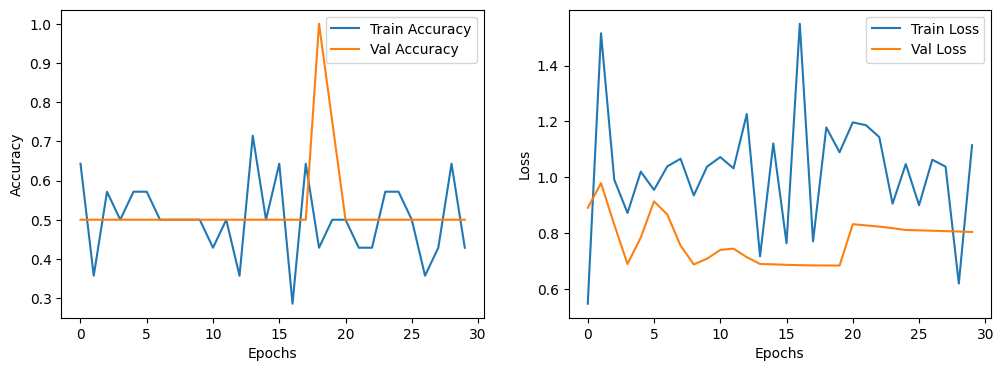

In [28]:
def plot_history(history: dict) -> None:
    metrics = ["accuracy", "loss"]
    plt.figure(figsize=(12, 4))
    for i, metric in enumerate(metrics):
        plt.subplot(1, 2, i + 1)
        plt.plot(history[metric], label=f"Train {metric.capitalize()}")
        plt.plot(history[f'val_{metric}'], label=f"Val {metric.capitalize()}")
        plt.xlabel("Epochs")
        plt.ylabel(metric.capitalize())
        plt.legend()
    plt.show()

if history:
    plot_history(history)


--- Evaluating on Test Set ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5000 - loss: 0.8505
Test Accuracy: 0.5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
              precision    recall  f1-score   support

     greater       0.50      1.00      0.67         1
    gspotted       0.00      0.00      0.00         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2



/Users/raoabdul/Documents/Development/NextGen-Innovators/nextgen/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/raoabdul/Documents/Development/NextGen-Innovators/nextgen/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/raoabdul/Documents/Development/NextGen-Innovators/nextgen/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zer

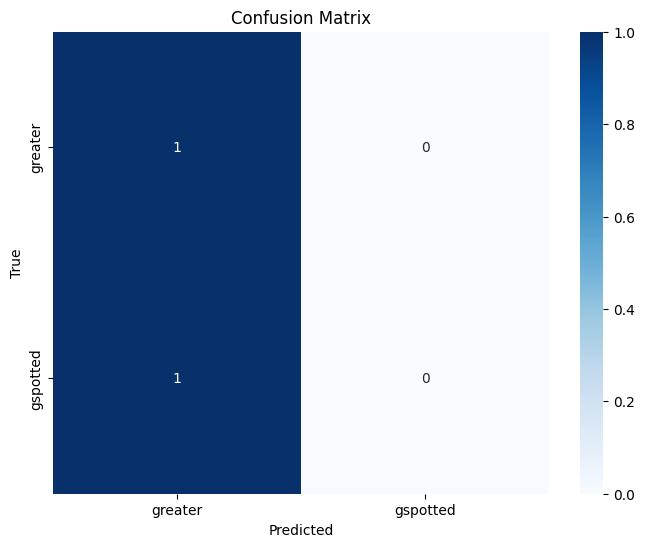

In [29]:
if data_bundle and data_bundle.get("test") and model:
    print("--- Evaluating on Test Set ---")
    test_loss, test_acc = model.evaluate(data_bundle["test"])
    print(f"Test Accuracy: {test_acc:.4f}")

    y_pred_probs = model.predict(data_bundle["test"])
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.concatenate([y for x, y in data_bundle["test"]], axis=0)
    y_true = np.argmax(y_true, axis=1)

    class_names = list(data_bundle["class_to_index"] .keys())
    print(classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()
else:
    print("Evaluation skipped. Test data or model not available.")


## **6. Save the Model**

Finally, we save the trained model and the class mapping for future use.

In [30]:
if model is not None and data_bundle is not None:
    model.save(ARTIFACT_DIR / "visual_classifier.keras")
    with open(ARTIFACT_DIR / "class_mapping.json", "w") as f:
        json.dump(data_bundle["index_to_class"], f, indent=4)
    print(f"Model saved to {ARTIFACT_DIR / 'visual_classifier.keras'}")
    print(f"Class mapping saved to {ARTIFACT_DIR / 'class_mapping.json'}")
else:
    print("Model not saved. Not available.")


Model saved to /Users/raoabdul/Documents/Development/NextGen-Innovators/ML Model/artifacts/visual_classifier.keras
Class mapping saved to /Users/raoabdul/Documents/Development/NextGen-Innovators/ML Model/artifacts/class_mapping.json
